# General introduction
Today, you will assemble and annotate a metagenome of a plant: *Azolla filiculoides*. *Azolla* is known for its endophytes: microorganisms that live inside the plant. These microorganisms live specifically inside a leaf cavity in every upper leaf lobe of the plant. One of these endophytes has been known for a long time: *Nostoc azollae* They are best known for fixing N^2 from the air, in service of the plant. The image included below illustrates the physiology of these leaf cavities. 

While the presence of *N. azollae* is well studied, the presence of other microbes in the *Azolla* leaf pocket is not. Today, we will create and analyse the metagenome of *A. filiculoides* plants, in search for these other "neglected" microbes. 

![image](http://theazollafoundation.org/wp-content/uploads/2013/05/Azolla-leaf-cavities-with-Anabaena.png)

Hence, the open biological question we are answering today is "which species live inside these leaf cavities and what are the metabolic capacities encoded on their genomes?" Based on these genomes, you may be able to infer their function and think of a hypotheses to test. 

*Tip*: If you stumble upon a step with a long calculation time, first read ahead to see what steps come next, and otherwise you can google some information about the plant you are researching. Notice that this [paper](http://onlinelibrary.wiley.com/doi/10.1111/nph.14843/full) specifically describes the data that we will be using today. For a more general introduction into Azolla, perhaps have a look at [this short movie](https://youtu.be/O34gTsxyDq8) or [this short movie](https://youtu.be/OI4VV4M2-f4) (Dutch) recorded for Dutch local television.


# Workflow

## Acquire Samples
A typical metagenomics workflow starts in the environment and/or the wetlab with a DNA extraction from some biological sample. This is also true for this workflow. We have extracted DNA from *Azolla* from the environment in two ways. Firstly, the whole Plant (P), secondly from the Leaf cavities (L). Both were collected in three biological replicates. Hence the samples we will work with are coded L1 L2 L3 and P1 P2 P3. The reasoning behind these two sampling types is that true endophytes are expected to be more abundant in leaf samples than in plant samples. So we may later use these different sampling types to infer if a microbial genome that we assembled originated from the leaf cavity, or from somewhere else in or on the plant. 

Extracted DNA is processed in a sequencing library; it is prepared in a way that a [Illumina sequencing](https://en.wikipedia.org/wiki/DNA_sequencing#Illumina_(Solexa)_sequencing) machine can process it. The sequencing machine then provides us with [FastQ](https://en.wikipedia.org/wiki/FASTQ_format) files, you may have handled these before, perhaps not. We will have a look at FastQ files later in this practical.

## First Quality Control and processing.
FastQ files contain the output of the Illumina sequencing machine: tens of millions of short DNA sequences. Where short is anything between 50 and 250 bp. These original short DNA sequences are further refered to as DNA reads, or just reads. FastQ files contain unprocessed output of the machine, every read consists of four lines: 
1. a header proceeded by the '@' character. 
2. the DNA sequence
3. a comment line proceeded by a '+'
4. a quality string.

The quality string has the exact same length as the DNA read, every character in the quality string corresponds to some number between 0 and 40. The sequencing machine assigns this quality score based on "how sure it is" that this specific base is correct. To put it a bit loosly.

These are two reads encoded in a FastQ file.

> @NS500813:28:H3M3VAFXX:1:11101:19270:1015 1:N:0:CGATGT
GNGGTGAAGAAATCAGCCATTCTAAACCAATTGCTCTCCAAGGATTATCAGGTGCTTTTTCACCTTGCGTCCAAGAAACCAAAATATTGAATATGAAGGGTAAGGTGGACATTCCTAATAAGAATGCACCAAGACTAGCGAGAACATTCC
+
A#AAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAEAEE<EEEEEEEEEEEEEEEEEEEEEAEEEAEEEEEEEEEEEEEEEEEEEEAAAEEAEEEEEAAAAA6AEAEAAEEEEEEEEEEEEA6
@NS500813:28:H3M3VAFXX:1:11101:24948:1015 1:N:0:CGATGT
ANATTAATTATACAATCACTAATTTAGCAGAGCATTTAGAAAGTATAAGCCATGATGCAATTAACTATTATTTAAAAACCGAAAAGTTAACATCTCGTTTACTATGGGATAAGGTGAAAGAGGTAGTAGAACCTGATGGTAATGGGTACAT
+
A#AAAAEEEEE6EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE/EEAEEEEEEEAEEEEEEEEEEE<EEE<EEEEE66EEA<EEEEAEEEEEEEEEEEAE<E/AE/EEEEEAEAAEAAAEEEEAEEEE6<EEAEA<//AAEEAEE<AA

FastQ files often contain some reads of poor quality, we definitively want to filter those out before starting our analyses. There are many ways available, for todays practical, this was done for you already with a tool called [trimmomatic](https://academic.oup.com/bioinformatics/article-abstract/30/15/2114/2390096).

Before and after trimming, general Quality Controll (QC( of a FastQ file is assessed with a tool called FastQC. The FastQC reports are rendered as html pages so we can view them in our webbrowsers. You can find the FastQC reports for this practical here:

### Filtering
Finally, we chose here to filter the sequencing data for plant DNA, since we are only interested in microbial DNA. The sequencing data was rid of any plant DNA by mapping (aligning) the reads to a reference plant genome. Only the sequencing data that did not map anything was kept for further analysis.

### laura add fastQC links


## Assembly
Assmbly is the process of combining these many short DNA reads in longer contiguous strings of DNA: contigs. For the assembly process we have used both sample types and all biological replicates as if they were one big sample. This yields the best assembly results. A metagenome assembly is different than a regular genome assembly in that it has DNA of multiple species in one sequencing file. Metagenome assembly was achieved with [SPAdes](http://online.liebertpub.com/doi/abs/10.1089/cmb.2012.0021). 

Some more elaborate information of Assembly
> The process of assembly takes the millions of short reads in a fastq file, and processes these to thousands of longer nucleotide sequences. Typically the output is a fasta file with contiguous sequences called contigs (contigs.fasta) or a fasta file with multiple contigs scaffolded based on their relative position and orientation to each other called scaffolds, in a file scaffolds.fasta. Ideally, these scaffolds represent the genome of a single species in the metagenome. This is however, extremely unlikely. At least in my personal experience. In reality the assembly process wil produce thousands of longer scaffolds where a single species' genome is still represented by multiple sequences in the assembly fasta file.

Also, you probably know what a fasta file is. It is a text file with DNA or protein sequences. A fasta file can contain multiple sequences. Fasta files are similar to fastq files, but a bit simpeler. There are just two types of lines. The header line is preceded by a `>` and the lines after contain the DNA sequence. The DNA sequence can continue until the next `>` or until the end of the document. We may have a quick look at a fasta file:
> \>Sequenceheader <br>
>  ACTCATGAGACTAGACA


# Here you will take over the workflow
We have provided you with a subset of the assembly and a subset of the reads. We have made subsets rather than the whole sets to keep this one day practical feasible. The complete workflow you will follow, is seen on this sketch below. Whenever you are lost in commandline, error messages and output tablaes, have a look again at this flowchart. In these bio-informatics workflows it is essential to keep a feeling for where you are, where you are going and where you come from.  
![image](./metagenomics/workflowsketch.png)

The programmes mentioned in the flowchart are preinstalled on this virtual machine you are currently working on:
bwa: http://bio-bwa.sourceforge.net/ <br>
samtools: http://samtools.sourceforge.net/ <br>
binningmetabat: https://bitbucket.org/berkeleylab/metabat/overview <br>
checkm: https://github.com/Ecogenomics/CheckM/wiki/Installation#how-to-install-checkm <br>
prokka: http://www.vicbioinformatics.com/software.prokka.shtml <br>


## Jupyter and Bash Basics
Before we will get our hands dirty with the 'real data', we will first do some exercises to learn how to work in a notebook like this then we will continue the metagenomics workflow. To keep all information central, I will continue here with the explaination of the workflow. The exercises will be available in another notebook after you have read the full introduction.

## Backmapping
After assembly of the scaffolds we want to know how abundant each scaffold is in the different metagenomic samples. To do this, we align the illumina reads (FastQ files) to the scaffolds (fasta) of the assembly in a step called **backmapping** with a tool called BWA (Burrows-wheeler aligner). BWA will provide us then with a table of which reads mapped on the metagenome assembly and their specific coördinates. This table is stored in a `.bam` file. Finally, these tables in the `.bam` files must be sorted by coördinate. This we achieve with a tool called `samtools`.

## Binning
A single metagenome assembly contains scaffolds representing DNA of many species in the original sample, but without any information on which scaffold belongs to which species. To tackle this issue, we will categorise each individual scaffold in a 'bin' which then ideally comprises one species in the metagenome. This procedure is called binning. The binning procudure needs the bam files we will make in the 'backmapping' step. The tool we use for binning is called `metabat`. Metabat uses the sorted bamfiles to subdivide the scaffolds in bins. This will produce between 5 and 20 bins. Hence we have moved from millions of very short sequences with very little biological information to thousands of longer scaffolds with more biological information, to dozens of long sequences with a lot of biological information. 

## QC
One bin ideally represents one species. To check whether this is the case, we can use the tool `checkM`. CheckM assesses the completeness and contamination of bins based on single-copy-marker-genes (collocated sets of genes that are ubiquitous and single-copy within a phylogenetic lineage). 

## Annotation
For the sake of simplicity and time, we will isolate one bin per group and annotate this bin using prokka. Annotation is the process of adding functional information to parts of DNA sequence, i.e. making a table of genes and locations of these genes. These are often stored in a GFF file, the genomic feature format. Once you have this gff file, and a fasta for your specific bin/microbial species, we will visualise it using KEGG. Again, for more details please google kegg. Here we will use it to load our gff file and then explore the metabolic pathways present. 


# Final remarks
Not all steps are feasible on these humble web based machines. Be paitient and don't overload the machines, if we crash the server we all loose acces to the notebooks.

Good luck! and remember Google is your friend!!!

# How to work in a Jupyter notebook with the Bash language
The webpage you are looking at, is called a jupyter notebook. It is a webpage on which you can write text (like this text) and also code. The code can ben executed an the output you see again within the same notebook! This may sound trivial, but it's really "cool". To put it in non-scientific terms. Code and text are entered in individual cells, a code cell or a text cell. This cell you are reading now is obviously a text cell. Now let's look at a code cell.

In [8]:
%%bash
echo "hello world"

hello world


So what happened in the above code cell. First I declared that I want to write code in bash by typing
> %%bash

then the first word you type in bash is always the command: in this case this is 
> echo

this command 'echoes' whatever you give it in the terminal.

after you 'call' the command, you give it an argument in this case that is 
> "hello world"

This basic structure of 'command' 'arguments' commes back through this practical. 

*do* now try to change "hello world" to something else

Often, an argument is a path to a file. To see what files we have, we have the `ls` command. (short for list)

In [3]:
%%bash
ls

COO1_C002.ipynb               dna181_circos.conf
COO3.ipynb                    dna181_denovo.vcf
COO4+Pipeline+building.ipynb  dna181_illumina.bam_CNVs
COO5a.ipynb                   Homo_sapiens.GRCh37.GATK.illumina@
COO5b.ipynb                   metagenomics/
COO6B_github.ipynb            metagenomics.ipynb
COO6.ipynb                    NGS analyses.ipynb
CWLs/                         sv.links
datafiles@                    WES_analysis_pipeline.sh*


Files are black, folders are purple and trailed by a '/'   Now lets use the `ls` command to see what is in the metagenomics folder

In [7]:
%%bash
ls metagenomics/

assembly
mapping
reads
sorted
workflowsketch.png


We are learning fast. So we now know what a `command` is, we know what an `argument` is. Finally we also need to know what options are. options are often provided in between the `command` and the `argument`. They look either like this
> ls --size --human-readable

or in shortened versions like this
> ls -sh

Note that the above two command are synonimous. Try out in the cell below:

In [8]:
%%bash 
ls --size --human-readable metagenomics/

total 652K
4.0K assembly
4.0K mapping
4.0K reads
4.0K sorted
636K workflowsketch.png


Finally, you may also choose not to specify `%%bash` at the beginning of a cell, but the precede a command with an exclamation mark instead. Like so

In [9]:
!ls -sh ./metagenomics/

total 652K
4.0K assembly  4.0K mapping  4.0K reads  4.0K sorted  636K workflowsketch.png


Wether you choose to use `%%bash` or `!` . Both work. Realise however that a `!` only works for that specific line you type in, and `%%bash` works for the entire cell. 


<h2> OLD Practical information </h2>
This whole computer practicum will take a whole day, staff will be present all day to help you in this process. However, we are with very few so please assisst each other where possible. 

You will work in this python notebook, combining bash and python commands. Bash commands can be executed by appending an exclamation mark '!' to the command like so:

> !whoami

Or by typing "%%bash" at the start of your code block, like so:

> %%bash


You are working on the virtual machine, which you have used before, did you know you can check the computer power of this machine using bash commands:

number of cpu threads

> !nproc

available GB RAM memory

> !top


The first bash commands we will use are 'mkdir' 'wget' and 'ls'. Go ahead and see what they do. If you wonder, most programms print a short summary of their function when presented the -h flag like so:

> !ls -h

or 

> !ls --help

or 

> !mkdir -h


If you made a directory you want to remove again you can use:

> !rm -rf directory

but be carefull with the rm command because you will not be able to recover the removed file.



## Raw data

<b> sequencing reads </b><br>
The sequencing reads are already available in the folder 'metagenomics/reads', to keep the practical feasible we have made a subset of the original data. <br>

In this reads folder you will find 12 files. <br>
L and P stand for the leaf and plant samples. <br>
L1 L2 L3 are the biological replicates. R1 and R2 represent the forward and reverse illumina reads. So 2 samples * 3 replicates * 2 directions = 12 files <br>
Files are stored in a fastq format (.fastq) and compressed in gzip archives (.gz). The gzip compression format is widely used in the genomics field, fastq files often compress down to only a quarter of the filesize with gzip! You do not need to extract these. <br>

A good practice is to always peek into a file just to check the format. 

This command allows you to see the files in the reads directory.   'ls' is short for 'list'

In [10]:
!ls metagenomics/reads/

L1.R1.fastq.gz	L2.R2.fastq.gz	P1.R1.fastq.gz	P2.R2.fastq.gz
L1.R2.fastq.gz	L3.R1.fastq.gz	P1.R2.fastq.gz	P3.R1.fastq.gz
L2.R1.fastq.gz	L3.R2.fastq.gz	P2.R1.fastq.gz	P3.R2.fastq.gz


To view in a gzipped file you can use the zcat command. 

The '|' sign is called a 'pipe' You can use it to feed the output of one programme to the next. Never forget to pipe the output to head when viewing/reading a file, like this "| head". The files we work with are big and will crash your jupyter-notebook instance if you don't use head.

In [11]:
!zcat metagenomics/reads/L1.R1.fastq.gz | head

@NS500813:28:H3M3VAFXX:1:11101:21566:1019 1:N:0:CAGATC
AAAAAATTAAAATAATTGGCTGAAAATGAAAAAAGAAAGCTTGATCATATGTTAAGCCTTTTGTAACGGAACAAAGTGATTAAATTATCTCTACAGTGTTTTTTCGATTTATTGATGGATTAAGAACAACCGTCACACACCAATAGAATAT
+
AAAAAEEEE6EEEEEEEEEEEEEEEEEEEEEAEEEEEEEEE</EE<EEEEEEEE/AA6E<E/E/</EEEAE/EEEEEEE<EEE//EEEEE<EE/EEAE<E<E//AE/E<EE/<AEEEAE66<E<<E</<AA<E/AEE/E//<<EEEEE/AA
@NS500813:28:H3M3VAFXX:1:11101:14840:1067 1:N:0:CAGATC
GTGGGATTTCCAGTGATTTGAATTCTTACAAAAGTCGCTTGCTTTTGTTTTTATTGCCACCTATTTCGTTGAATAATTATTAGAAAGGGAACAAGGCTTTTTGACGATAAAAAGTTATTTTTAATTGGAGGTCGCTAGAATAGCTTTGTT
+
A/AAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAEEEEAEEAEEEEEEEEEEEEEAEEE/EE/EEEEEEAEEEEEEEEEAEEEEEEEEEA/EEEAEAA<EEEEEEEEEAAEA/A/AA/6A<E<AE/EA6<A
@NS500813:28:H3M3VAFXX:1:11101:20510:1074 1:N:0:CAGATC
CCCGGTGCTGAATGAGAATGATTCGTGTTTAGATTAGCAGGCGCTGATGGTAGTAGTAGCGGCAATGAGAGTGATTCGTATTTAGATCCAGGCAGGGGCGGAAGTTTCATAATGTGGAATGCGCCCTGGTGCGCTTTACAATGTAAAGC

gzip: stdout: Broken pipe


Using grep we can select for lines in a file that contain only the word/key specified in the grep command. As you can see in the above command, the headers of the reads always start with the "@", therefor if we only want to see the headers we can simply grep for the "@" using the command below:

In [12]:
!zcat metagenomics/reads/L1.R1.fastq.gz | grep '@' | head

@NS500813:28:H3M3VAFXX:1:11101:21566:1019 1:N:0:CAGATC
@NS500813:28:H3M3VAFXX:1:11101:14840:1067 1:N:0:CAGATC
@NS500813:28:H3M3VAFXX:1:11101:20510:1074 1:N:0:CAGATC
@NS500813:28:H3M3VAFXX:1:11101:5773:1086 1:N:0:CAGATC
@NS500813:28:H3M3VAFXX:1:11101:2702:1014 1:N:0:CAGATC
@NS500813:28:H3M3VAFXX:1:11101:6665:1015 1:N:0:CAGATC
@NS500813:28:H3M3VAFXX:1:11101:6357:1086 1:N:0:CAGATC
@NS500813:28:H3M3VAFXX:1:11101:18737:1028 1:N:0:CAGATC
@NS500813:28:H3M3VAFXX:1:11101:1677:1028 1:N:0:CAGATC
@NS500813:28:H3M3VAFXX:1:11101:26277:1020 1:N:0:CAGATC
grep: write error: Broken pipe

gzip: stdout: Broken pipe


Now if we want to count the number of reads in the fastq file we can count the number of headers, since every entry has one header. To count the number of headers we will first have to read in the gzip file, then grep on the headers, and then we can use the wordcount command to count the number of lines.

In [13]:
!zcat metagenomics/reads/L1.R1.fastq.gz | grep '@' | wc -l

1000000


### wrap up
So now you have executed some bash commands and investigated the output. 

## Assembled data

Calculating a de-novo metagenome assembly is beyond the scope of this practical, so we have done this for you. You will however analyse this assembly yourself! :)

View the inside of the assembly directory:

In [14]:
!ls metagenomics/assembly/

allscaffolds.fasta.gz  scaffolds.fasta.ann  scaffolds.fasta.pac
scaffolds.fasta        scaffolds.fasta.bwt  scaffolds.fasta.sa
scaffolds.fasta.amb    scaffolds.fasta.gz


Now your first assignment is to dowload the assemblies from the data repository, adapting the commands above. Below you will find a code block with the template command that you can finish to download the the assemblies. Use multiple code blocks if convenient. You can make new code blocks by clicking on the left side of a code block and then type "a" or "b" to create a code block above or below the original code block. You can delete a code block by clicking on the left side of a code block and typing "d" twice.

Edit this line to have a look into the assembly file

In [6]:
!zcat metagenomics/assembly/....assemblyfile | head

gzip: metagenomics/assembly/....assemblyfile.gz: No such file or directory


Grep the headers of the assembly file, what word/key would work for fastas when viewing the assembly entries above

In [ ]:
!zcat metagenomics/assembly/....assemblyfile | grep "" | head

Count the scaffolds in the assembly like we did earlier with the fastq.gz file. 

Remember not to over-load the webinterface!

In [ ]:
!zcat metagenomics/assembly/....assemblyfile | grep "" ......

Rename the assembly file:   (mv is short for move)

In [ ]:
!mv metagenomics/assembly/....oldname  metagenomics/assembly/....newname

Check if the rename worked:

In [ ]:
!ls metagenomics/assembly/

Did your assembly downloaded correctly?<br>
Does the content of the fasta make sense?<br>

<h2>Length distributions of the scaffolds</h2>
Now that we have the assembly, we will do some quick analyses to get a idea of the quality. First we will plot the length distribution of the scaffolds in the assembly. Luckily for us, the length of each sequence in the fasta is already embeded in each fasta header. We can easily extract these numbers and plot them in python.

To plot the length distribution run the python code below.

In [13]:
%%bash
ls ./metagenomics/assembly/
gunzip --keep ./metagenomics/assembly/scaffolds.fasta.gz

scaffolds.fasta.gz


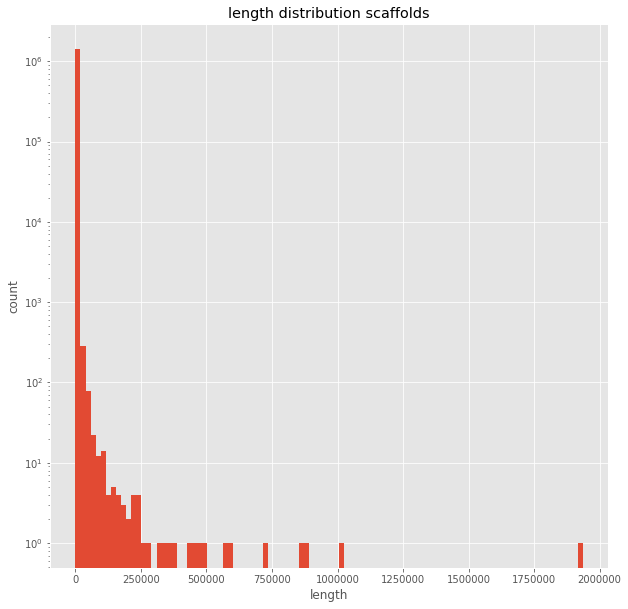

In [14]:
import matplotlib.pyplot as plt
import re
%matplotlib inline  
plt.style.use('ggplot')

f = open("./metagenomics/assembly/scaffolds.fasta", "r")
lines = f.readlines()
f.close()

data = []
regexp = re.compile(">")

for line in lines:
    if re.search(regexp, line):
        line = line.strip().split('_')
        data.append(float(line[3]))
        
fig = plt.figure(figsize=(10,10))
plt.hist(data, bins=100, log=True);
plt.title("length distribution scaffolds");
plt.xlabel("length");
plt.ylabel("count");

Did you expect this distribution?<br>
Why would there be so many short scaffolds?<br>

<h2> Mapping reads to scaffolds with bwa (Burrows-Wheeler Aligner) and sorting with Samtools</h2>
We now have the reads and the assembly so we can start by mapping (aligning) the original reads back to the scaffolds created with the assembly. Doing this will allow us to see the read depth on the scaffolds.

The reads are paired-end, which means that for each DNA fragment, we have sequence data from both ends. The sequences are therefore stored in two separate files (one for the data from each end). We’ll use bwa’s default settings to align the reads back and then Samtools allows us to work with the bwa results.

<b>Assignment:</b><br>
Use bwa to backmap the reads against the scaffolds and save the mapping as a .bam file.
(because we want to map all the reads back we helped you a bit with the commands).

(1) To run bwa we first need to make an index file of the scaffolds. <br>
(2) Then we can run bwa and immediatly pipe the output of bwa through samtools view which will output a bam file <br>
(3) Finally the bam file has to be sorted using Samtools sort.


some background: By default mapping algorithms like bwa spit out a .sam file. The sam format is widely used and accepted by many different downstream programmes. Basically it's just a big table with a standardised format. Although a sam file is human readable, it is also rather bulky. The filesize of a single SAM file will quickly exceed the disk space you have on this virtual machine. Therefore, we convert it to a BAM file, which is a Binary sAM file. There is no loss of information, it is just stored much more efficiently. Naturally, a binary file is not human readable. Always store your files as bam files, if you need to have a look in the bam file you can view them using samtools view or any of the many downstream programmes available online.

bwa help page:

In [15]:
!bwa


Program: bwa (alignment via Burrows-Wheeler transformation)
Version: 0.7.17-r1188
Contact: Heng Li <lh3@sanger.ac.uk>

Usage:   bwa <command> [options]

Command: index         index sequences in the FASTA format
         mem           BWA-MEM algorithm
         fastmap       identify super-maximal exact matches
         pemerge       merge overlapping paired ends (EXPERIMENTAL)
         aln           gapped/ungapped alignment
         samse         generate alignment (single ended)
         sampe         generate alignment (paired ended)
         bwasw         BWA-SW for long queries

         shm           manage indices in shared memory
         fa2pac        convert FASTA to PAC format
         pac2bwt       generate BWT from PAC
         pac2bwtgen    alternative algorithm for generating BWT
         bwtupdate     update .bwt to the new format
         bwt2sa        generate SA from BWT and Occ

Note: To use BWA, you need to first index the genome with `bwa index'.
      There are

samtools help page:

In [16]:
!samtools


Program: samtools (Tools for alignments in the SAM format)
Version: 1.7 (using htslib 1.7-2)

Usage:   samtools <command> [options]

Commands:
  -- Indexing
     dict           create a sequence dictionary file
     faidx          index/extract FASTA
     index          index alignment

  -- Editing
     calmd          recalculate MD/NM tags and '=' bases
     fixmate        fix mate information
     reheader       replace BAM header
     targetcut      cut fosmid regions (for fosmid pool only)
     addreplacerg   adds or replaces RG tags
     markdup        mark duplicates

  -- File operations
     collate        shuffle and group alignments by name
     cat            concatenate BAMs
     merge          merge sorted alignments
     mpileup        multi-way pileup
     sort           sort alignment file
     split          splits a file by read group
     quickcheck     quickly check if SAM/BAM/CRAM file appears intact
     fastq          converts a BAM to a FASTQ
     fasta       

<b>run bwa index on default to make index files of your scaffolds (so no need for options)</b>

bwa index help page:

In [ ]:
!bwa index

run bwa index, finish the code: 

In [ ]:
!bwa index ....

In [17]:
!bwa index ./metagenomics/assembly/scaffolds.fasta

[bwa_index] Pack FASTA... 4.47 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=1207810830, availableWord=96985660
[BWTIncConstructFromPacked] 10 iterations done. 99999998 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 199999998 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 299999998 characters processed.
[BWTIncConstructFromPacked] 40 iterations done. 399999998 characters processed.
[BWTIncConstructFromPacked] 50 iterations done. 499999998 characters processed.
[BWTIncConstructFromPacked] 60 iterations done. 597255246 characters processed.
[BWTIncConstructFromPacked] 70 iterations done. 684196110 characters processed.
[BWTIncConstructFromPacked] 80 iterations done. 761465326 characters processed.
[BWTIncConstructFromPacked] 90 iterations done. 830138430 characters processed.
[BWTIncConstructFromPacked] 100 iterations done. 891171246 characters processed.
[BWTIncConstructFromPacked] 110 iterations done. 94

<b>check the output of bwa</b><br>
there should now be multiple files in the assembly folder <br>
think about what command you could use to look at the files in a directory

In [15]:
!ls ./metagenomics/assembly/

allscaffolds.fasta.gz  scaffolds.fasta.ann  scaffolds.fasta.pac
scaffolds.fasta        scaffolds.fasta.bwt  scaffolds.fasta.sa
scaffolds.fasta.amb    scaffolds.fasta.gz


<b>run bwa mem for backmapping</b>

For this part we will use a bash for loop to run bwa mem and samtools view on all the reads in metagenomics/reads and  create BAM output files in a newly made directory

Then we use a bash for loop to run samtools sort on all the files created by samtools view

Step by step instruction:<br>
1. make a new directory for the samtools view results, give this a usefull name<br>
2. finish the for loop and run both `bwa mem` and `samtools view` <br>
3. make a new directory for the samtools sort results, give this a usefull name<br>
4. finish the for loop and run samtools sort<br>

Mapping each individual sample will take about 5 to 6 minutes

bwa mem help page:

In [32]:
!bwa mem


Usage: bwa mem [options] <idxbase> <in1.fq> [in2.fq]

Algorithm options:

       -t INT        number of threads [1]
       -k INT        minimum seed length [19]
       -w INT        band width for banded alignment [100]
       -d INT        off-diagonal X-dropoff [100]
       -r FLOAT      look for internal seeds inside a seed longer than {-k} * FLOAT [1.5]
       -y INT        seed occurrence for the 3rd round seeding [20]
       -c INT        skip seeds with more than INT occurrences [500]
       -D FLOAT      drop chains shorter than FLOAT fraction of the longest overlapping chain [0.50]
       -W INT        discard a chain if seeded bases shorter than INT [0]
       -m INT        perform at most INT rounds of mate rescues for each read [50]
       -S            skip mate rescue
       -P            skip pairing; mate rescue performed unless -S also in use

Scoring options:

       -A INT        score for a sequence match, which scales options -TdBOELU unless overridden [1]
     

samtools view help page:

In [ ]:
!samtools view

In [18]:
rm ./metagenomics/mapping/ -rf

In [19]:
mkdir ./metagenomics/mapping

In [20]:
ls ./metagenomics/reads/

L1.R1.fastq.gz  L2.R2.fastq.gz  P1.R1.fastq.gz  P2.R2.fastq.gz
L1.R2.fastq.gz  L3.R1.fastq.gz  P1.R2.fastq.gz  P3.R1.fastq.gz
L2.R1.fastq.gz  L3.R2.fastq.gz  P2.R1.fastq.gz  P3.R2.fastq.gz


In [21]:
%%bash
samples=$(find ./metagenomics/reads -name '*.fastq.gz' -type f -printf '%P\n' | cut -d '.' -f 1 | sort | uniq)
for i in $samples
    do echo $i
    bwa mem -t 1  ./metagenomics/assembly/scaffolds.fasta ./metagenomics/reads/"$i".R1.fastq.gz ./metagenomics/reads/"$i".R2.fastq.gz | samtools view -h -b > ./metagenomics/mapping/mapped."$i".bam 
done

L1
L2
L3
P1
P2
P3


[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 68246 sequences (10000095 bp)...
[M::process] read 68222 sequences (10000032 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (5, 20948, 2, 2)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (359, 418, 514)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (49, 824)
[M::mem_pestat] mean and std.dev: (434.33, 134.40)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 979)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 68246 reads in 10.325 CPU sec, 10.192 real sec
[M::process] read 68066 sequences (10000164 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (12, 20931, 2, 0)
[M::mem_pestat] analyzing insert

In [22]:
!ls ./metagenomics/mapping/ -l

total 1337764
-rw-rw-r-- 1 laura laura 230239629 May 30 12:08 mapped.L1.bam
-rw-rw-r-- 1 laura laura 229849912 May 30 12:13 mapped.L2.bam
-rw-rw-r-- 1 laura laura 229877774 May 30 12:18 mapped.L3.bam
-rw-rw-r-- 1 laura laura 226385741 May 30 12:24 mapped.P1.bam
-rw-rw-r-- 1 laura laura 226103199 May 30 12:29 mapped.P2.bam
-rw-rw-r-- 1 laura laura 227392875 May 30 12:35 mapped.P3.bam


samtools sort help page:

In [ ]:
!samtools sort

In [26]:
%%bash
for i in ./metagenomics/mapping/*.bam ;
    do echo $i.sorted
    samtools sort -o "$i.sorted" "$i"
done

./metagenomics/mapping/mapped.L1.bam.sorted
./metagenomics/mapping/mapped.L2.bam.sorted
./metagenomics/mapping/mapped.L3.bam.sorted
./metagenomics/mapping/mapped.P1.bam.sorted
./metagenomics/mapping/mapped.P2.bam.sorted
./metagenomics/mapping/mapped.P3.bam.sorted


remove the samtools view directory:

In [51]:
%%bash
pwd
du -h ./metagenomics/

/home/laura/gitprojects/metagenomicspractical
2.0G	./metagenomics/assembly
946M	./metagenomics/reads
4.0K	./metagenomics/sorted
2.8G	./metagenomics/mapping
5.7G	./metagenomics/


In [ ]:
!rm -rf ....yourdirectoryname

samtools help page:

In [ ]:
!samtools view

run samtools view to view your BAM files:

In [ ]:
!samtools view ....yourbamsortedbam | head

<h2> Binning with MetaBat </h2>

Now that we have the reads, the scaffolds and the mapping of the reads on the scaffolds we can continue with the binning. In metagenomics, binning is the process of grouping reads or contigs and assigning them to operational taxonomic units. Binning methods can be based on either compositional features or alignment (similarity), or both. Metabat uses both the contig depth and tetra-nucleotide frequencies to bin the contigs. Every bin will represent one operational taxonomic unit that can be found in the metagenome.

<b>Assignment:</b><br>
Run the script provided in /metagenomics/scripts/jgi_summarize_bam_contig_depths to calculate the average depth per contig. <br>
Then run metabat to bin the contigs, dont forget to include the previously included contig depths in the metabat command.

In [52]:
!./metagenomics/scripts/jgi_summarize_bam_contig_depths -h

/bin/sh: 1: ./metagenomics/scripts/jgi_summarize_bam_contig_depths: not found


calculate the contig depth per scaffold<br>
hint: a glob looks like this directoryname/* and includes all files included in the directory

In [ ]:
!./metagenomics/scripts/jgi_summarize_bam_contig_depths --outputDepth 

metabat help page:

In [ ]:
!metabat -h

make a new directory:

In [ ]:
!mkdir

run metabat:

In [ ]:
!metabat -i -o -t

<h2> Checking completeness and contamination using CheckM </h2>

Now that we have the bins made with metabat we can check them for contamination and completeness (quality), for this we will use CheckM. CheckM provides a set of tools for assessing the quality of genomes recovered from isolates, single cells, or metagenomes. It provides robust estimates of genome completeness and contamination by using collocated sets of genes that are ubiquitous and single-copy within a phylogenetic lineage (also called marker/signature genes). http://ecogenomics.github.io/CheckM/

As you will be able to see in the checkm help pages, checkm has a workflow (lineage_wf) that will run all nessecary steps to asses bin quality. 

Lineage_wf (lineage-specific workflow) steps: <br>
- The tree command places genome bins into a reference genome tree. <br>
- The lineage_set command creates a marker file indicating lineage-specific marker sets suitable for evaluating each genome. <br>
- This marker file is passed to the analyze command in order to identify marker genes and estimate the completeness and contamination of each genome bin.  <br>
- Finally, the qa command can be used to produce different tables summarizing the quality of each genome bin. <br>


<b>Assignment:</b><br>
Sadly for this exercise the virtual machines we are using are not powerfull enough, therefore we provide the results of the first steps of the CheckM workflow up until the qa command (lineage_wf). Scan the help pages of CheckM to find out the correct command to finish the CheckM analysis. 

(OPTIONAL: you can try to find out what the limiting factor is of lineage_wf using !/usr/bin/time --verbose) <br>

In [ ]:
!checkm -h

In [ ]:
!checkm lineage_wf -h

checkm qa help page:

In [ ]:
!checkm qa -h

run checkm qa:

In [ ]:
!checkm qa

(think and discuss these questions) <br>

What did you do? <br>
Where is your output? <br>
What does your output look like? <br>
What can you say about the bins with this output? <br>
What can you say about lineages of the bins?<br>

<h2>Genome annotation with Prokka</h2>

Now that we some extra information about our bins, we can continue to analyze the high quality bins. The final CheckM results will give you a good overview of the bins with low contamination and high completeness and also shows the lowest taxonomic rank of the bin. Pick a bin that you think is interesting to further study.

With this bin we are going to do some genome annotation. Whole genome annotation is the process of identifying features of interest in a set of genomic DNA sequences, and labelling them with useful information. Prokka is a software tool to annotate bacterial, archaeal and viral genomes quickly and produce standards-compliant output files.

<b>Assignment:</b><br>
Have a look at the prokka help pages below and come up with the right command to run prokka. (HINT: look at the Usage tag to run prokka on default mode, think of threads, use --centre X --compliant to stop prokkas complaints about ugly contig names, direct the output towars metagenomics/prokka)

In [ ]:
!prokka

make a directory for the prokka output:

In [ ]:
!mkdir

prokka help page:

In [ ]:
!prokka -h

run prokka:

In [ ]:
!prokka --cpus --outdir 

(think and discuss these questions) <br>

What did you do? <br>
Where is your output? <br>
What does your output look like? <br>
Do you know what all the output files are or mean? <br>

(HINT: you can look at the prokka files in the same way we looked at the reads and scaffold earlier)

<b>investigating prokka output</b><br>
to investigate the prokka output you can use two webservers that both are able to place the annotations from prokka in KEGG pathways.<br>

(1) prokka gives uniprot IDs in the gff files first we will collect these IDs,
(2) since we have Uniprot IDs from prokka we are going to convert these to KO IDs that can be used by KEGG using this website:<br>
http://www.uniprot.org/uploadlists/

(3) then you can put your IDs in both websites and investigate the pathways
http://www.genome.jp/kegg/tool/map_module.html<br>
http://pathways.embl.de/iPath2.cgi#<br>

view prokka output:

In [ ]:
!less ....yourprokkaoutput.gff | head

take the uniprot IDs out of the gff file

In [ ]:
!grep -o 'UniProt.*' ....yourprokkaoutput | cut -d';' -f1 | cut -d':' -f2 > listofuniprotIDs